In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy import stats

from analyses_helper import calc_smi

import importlib

import analyses_helper
importlib.reload(analyses_helper)
from analyses_helper import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data and print out parameter combinations 
data = pd.read_pickle(r'../data/model_results/nmda_ampa_alpha.pkl')
data[["NMDA_WEIGHT", "AMPA_WEIGHT", "GABA_WEIGHT"]] = data[["NMDA_WEIGHT", "AMPA_WEIGHT", "GABA_WEIGHT"]].apply(pd.to_numeric)
data[["AMPA_WEIGHT", "NMDA_WEIGHT", "GABA_WEIGHT", "DELAY"]] = data[["AMPA_WEIGHT", "NMDA_WEIGHT", "GABA_WEIGHT", "DELAY"]].astype(float)
data.groupby(["NMDA_WEIGHT", "AMPA_WEIGHT", "GABA_WEIGHT", "ALPHA"]).apply(lambda x: np.max(x['ITER']))

NMDA_WEIGHT  AMPA_WEIGHT  GABA_WEIGHT  ALPHA
0.00         0.5          0.00         0.2      9
                                       0.4      9
                                       0.6      9
                                       0.8      9
                                       1.0      9
                          0.01         1.0      9
                          0.03         1.0      9
                          0.05         1.0      9
0.05         0.5          0.00         1.0      9
                          0.01         1.0      9
                          0.03         1.0      9
                          0.05         1.0      9
dtype: object

In [14]:
# calculate smi distributions 
smis = data.groupby(['AMPA_WEIGHT', 'NMDA_WEIGHT', 'GABA_WEIGHT', 'ALPHA', 'clipA', 'clipB', 'DELAY']).apply(lambda x: calc_smi(x)).reset_index()
smi_vals = pd.DataFrame(smis[0].tolist(), columns=['ra', 'rb', 'rab', 'smi'])
smis = smis.join(smi_vals)

max_smi = smis.groupby(['AMPA_WEIGHT', 'NMDA_WEIGHT', 'GABA_WEIGHT', 'ALPHA', 'clipA', 'clipB']).apply(lambda x: calc_max_smi(x)).reset_index()
max_vals = pd.DataFrame(max_smi[0].tolist(), columns=['smi', 'DELAY'])
max_smi = max_smi.join(max_vals)

/home/gwa18/auditory/code/dendritic_integration/analyses/analyses_helper.py:39: RuntimeWarning: divide by zero encountered in scalar divide
/home/gwa18/auditory/code/dendritic_integration/analyses/analyses_helper.py:39: RuntimeWarning: invalid value encountered in scalar divide


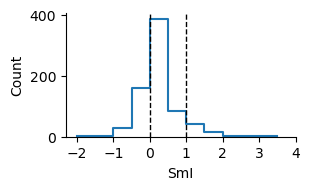

In [30]:
# figure 4a
ampa_only = smis[(smis['ALPHA']=="1.0") & 
                 (smis['NMDA_WEIGHT']==0.0) &
                 (smis['GABA_WEIGHT']==0.0)]

upper = np.ma.masked_invalid(ampa_only['smi'].values).max()
ampa_clip = ampa_only
ampa_clip.loc[ampa_only['smi'] == np.inf, 'smi'] = upper + 1 

plot_hist(ampa_clip, (3.2, 2))
#plt.savefig("./figs/ampa05.pdf", transparent=True, dpi=500)

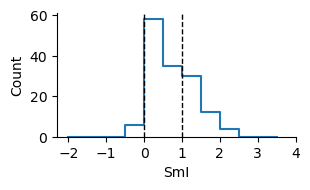

In [27]:
# figure 4b
ampa_max = max_smi[(max_smi['ALPHA']=="1.0") & 
                 (max_smi['NMDA_WEIGHT']==0.0) &
                 (max_smi['GABA_WEIGHT']==0.0)]

plot_hist(ampa_max, (3.2, 2))

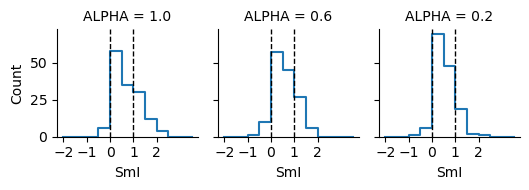

In [20]:
# figure 4c 
alpha_max = max_smi[(max_smi['GABA_WEIGHT']==0.0) & 
                    (max_smi['NMDA_WEIGHT']==0.0)]

alpha_max_sub = alpha_max[(alpha_max['ALPHA']=="1.0") |
                          (alpha_max['ALPHA']=="0.6") |
                          (alpha_max['ALPHA']=="0.2")]

alpha_max_sub['ALPHA'] = alpha_max_sub['ALPHA'].astype('category')
alpha_max_sub['ALPHA'] = alpha_max_sub['ALPHA'].cat.reorder_categories(["1.0", "0.6", "0.2"])

g = sns.FacetGrid(data=alpha_max_sub, col="ALPHA", height=2, aspect=0.9)
g.map(sns.histplot, "smi", bins=np.arange(-2, 4, 0.5), element="step", fill=None)
g.refline(x=0, linestyle='--', color='k', linewidth=1.0)
g.refline(x=1, linestyle='--', color='k', linewidth=1.0)
g.set(xticks=np.arange(-2, 2.5, 1))
g.set(xlabel="SmI")
#plt.savefig("./figs/alpha.pdf", transparent=True, dpi=500)

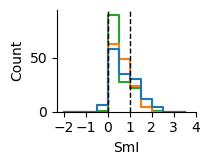

In [34]:
# figure 4d 
sns.reset_defaults()
nmda_smi = max_smi[(max_smi['NMDA_WEIGHT']==0.05) &
                   (max_smi['GABA_WEIGHT']!=0.01) &
                   (max_smi['GABA_WEIGHT']!=0.05)] 
nmda_smi['params'] = max_smi['NMDA_WEIGHT'] + max_smi['GABA_WEIGHT']

ampa_only = max_smi[(max_smi['NMDA_WEIGHT']==0.0) & (max_smi['ALPHA']=="1.0") & (max_smi['GABA_WEIGHT']==0)]
ampa_only['params'] = 0

nmda_ampa = pd.concat([ampa_only, nmda_smi], ignore_index=True)
nmda_ampa['params'] = nmda_ampa['params'].astype('category')

plot_hist(nmda_ampa, (2.2, 1.75))

In [38]:
# overlap between dendritic profiles 
dist = pd.read_pickle(r"../data/model_results/dendrites_ampa.pkl")
dist2 = dist[["clipA", "clipB", "DELAY"]]
dist2['tcorr'] = np.nan
dist2['scorr'] = np.nan

for index, row in dist.iterrows():
    d1 = pd.DataFrame(row['A']).to_numpy().T
    d2 = pd.DataFrame(row['B']).to_numpy().T

    d1_t = np.nansum(d1, axis=0)
    d2_t = np.nansum(d2, axis=0)

    d1_s = np.nansum(d1, axis=1)
    d2_s = np.nansum(d2, axis=1)

    dist2.loc[index, 'tcorr'] = np.corrcoef(d1_t, d2_t)[0, 1]
    dist2.loc[index, 'scorr'] = np.corrcoef(d1_s, d2_s)[0, 1]

dist2['DELAY'] = pd.to_numeric(dist2['DELAY'])

new_df = ampa_max.merge(dist2, how="left", on=['clipA', 'clipB', 'DELAY'])
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.dropna(inplace=True)

a1 = new_df[(new_df['tcorr'] > 0.3) & (new_df['scorr'] < 0.1)]
a1['labs'] = "dis_cor"
a2 = new_df[(new_df['tcorr'] < 0.3) & (new_df['scorr'] > 0.1)]
a2['labs'] = "clu_un"

compare = pd.concat([a1, a2])

stats.kruskal(a1['smi'].values, a2['smi'].values)


#fig, ax = plt.subplots(figsize=(2, 2))
#sns.boxplot(data=compare, x="labs", y="smi", color="black", fill=False, showfliers=False, ax=ax)
#sns.stripplot(data=compare, x="labs", y="smi", color="gray", alpha=0.8,  marker="$\circ$", ax=ax)
#sns.despine()
#plt.tight_layout()
#plt.savefig("./figs/boxplot.pdf", transparent=True, dpi=500)

KruskalResult(statistic=224.6489304375093, pvalue=8.757503070391349e-51)

KeyboardInterrupt: 

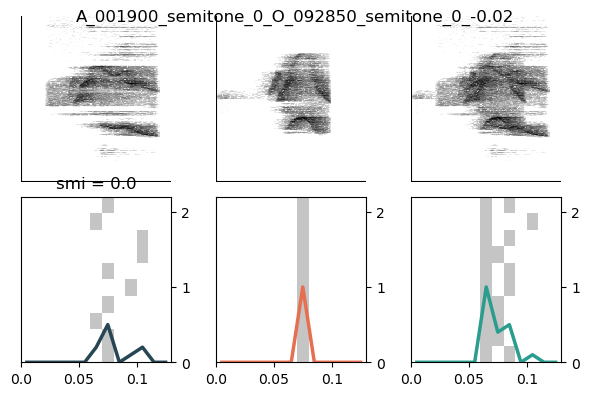

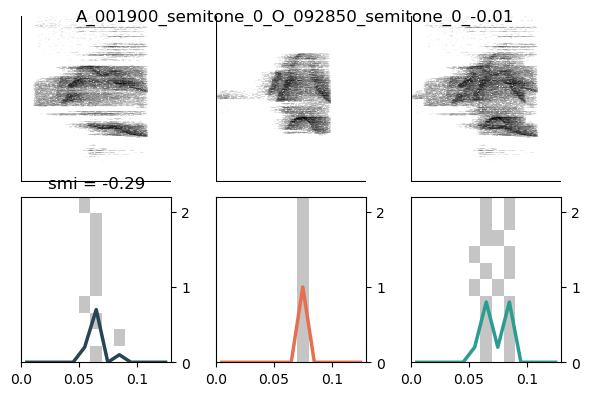

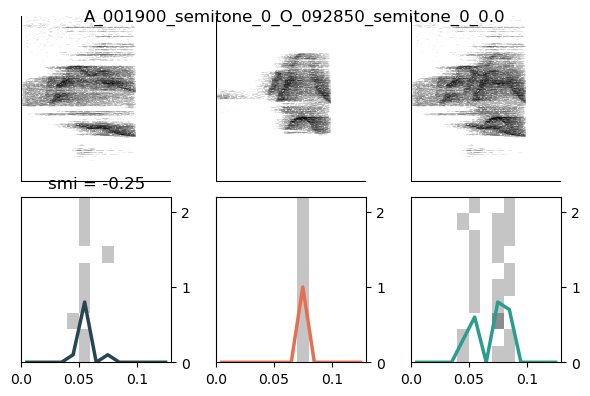

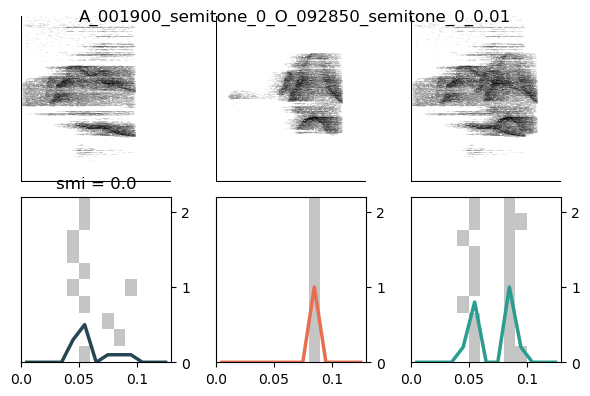

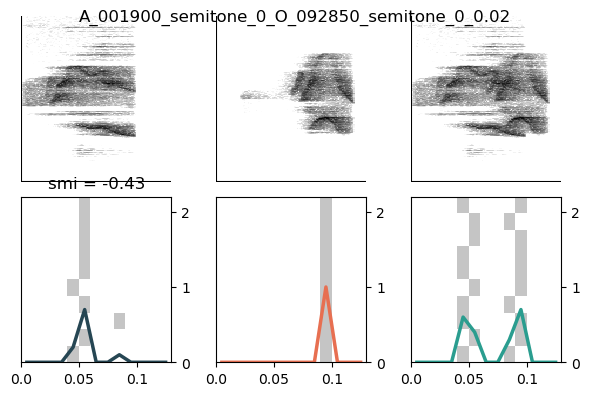

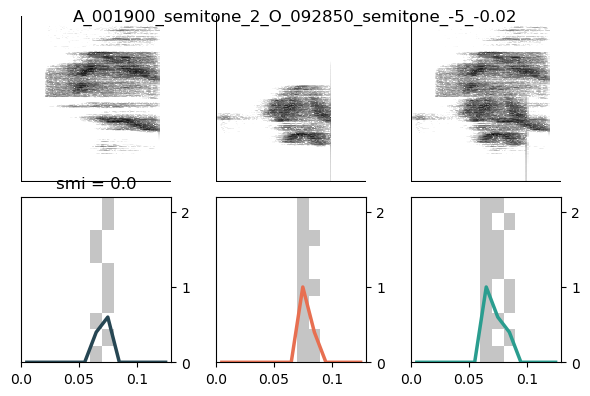

In [12]:
# plot individual combis
clip_files_dir =  "../data/audio_clips"
raw_set = data[(data['AMPA_WEIGHT'] == 0.5) & (data['NMDA_WEIGHT'] == 0.0) & (data['GABA_WEIGHT']==0.0) & (data['ALPHA']=="1.0")]
param_config = "AMPA_" + str(raw_set['AMPA_WEIGHT'].values[0]) + "NMDA_" + str(raw_set['NMDA_WEIGHT'].values[0]) + "GABA_" + str(raw_set['GABA_WEIGHT'].values[0])
out_folder = os.path.join("../results_plots/", param_config)
window = [0, 0.13]

if not os.path.exists(out_folder):
    os.mkdir(out_folder)

raw_set['clipname'] = raw_set['clipA'] + '_' + raw_set['clipB'] + '_' + raw_set['DELAY'].astype(str)
raw_set.groupby(['clipA', 'clipB', 'DELAY']).apply(lambda x: plot_func(x, clip_files_dir, out_folder, window)).reset_index()

In [11]:
raw_set['DELAY']

0       -0.02
1       -0.02
2       -0.02
3       -0.02
4       -0.02
         ... 
14585    0.02
14586    0.02
14587    0.02
14588    0.02
14589    0.02
Name: DELAY, Length: 7300, dtype: float64

In [22]:
raw_set

,A,B,AB,DELAY,B_CURRENT,NMDA_WEIGHT,AMPA_WEIGHT,GABA_WEIGHT,ALPHA,ITER,clipA,clipB,clipname
0,[0.0572],[0.0352],[0.0364],-0.02,200*pA,0.0,0.5,0.0,1.0,0,C_023460_semitone_-4,H_023460_semitone_2,C_023460_semitone_-4_H_023460_semitone_2_0 ...
1,[0.055600000000000004],[0.035300000000000005],"[0.037000000000000005, 0.08320000000000001]",-0.02,200*pA,0.0,0.5,0.0,1.0,1,C_023460_semitone_-4,H_023460_semitone_2,C_023460_semitone_-4_H_023460_semitone_2_0 ...
2,[0.0548],[0.0373],"[0.0337, 0.0597]",-0.02,200*pA,0.0,0.5,0.0,1.0,2,C_023460_semitone_-4,H_023460_semitone_2,C_023460_semitone_-4_H_023460_semitone_2_0 ...
3,[0.056100000000000004],[0.0371],"[0.0351, 0.059500000000000004]",-0.02,200*pA,0.0,0.5,0.0,1.0,3,C_023460_semitone_-4,H_023460_semitone_2,C_023460_semitone_-4_H_023460_semitone_2_0 ...
4,[0.058],[0.038400000000000004],"[0.0354, 0.0591]",-0.02,200*pA,0.0,0.5,0.0,1.0,4,C_023460_semitone_-4,H_023460_semitone_2,C_023460_semitone_-4_H_023460_semitone_2_0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585,[0.043000000000000003],[0.0845],"[0.0388, 0.0815]",0.02,200*pA,0.0,0.5,0.0,1.0,5,A_001900_semitone_0,O_092850_semitone_0,A_001900_semitone_0_O_092850_semitone_0_0 ...
14586,[0.040100000000000004],[0.08460000000000001],"[0.0388, 0.0806]",0.02,200*pA,0.0,0.5,0.0,1.0,6,A_001900_semitone_0,O_092850_semitone_0,A_001900_semitone_0_O_092850_semitone_0_0 ...
14587,[0.041],[0.0838],"[0.040600000000000004, 0.0818]",0.02,200*pA,0.0,0.5,0.0,1.0,7,A_001900_semitone_0,O_092850_semitone_0,A_001900_semitone_0_O_092850_semitone_0_0 ...
14588,[0.042100000000000005],[0.0845],"[0.0407, 0.0795]",0.02,200*pA,0.0,0.5,0.0,1.0,8,A_001900_semitone_0,O_092850_semitone_0,A_001900_semitone_0_O_092850_semitone_0_0 ...
